<a href="https://colab.research.google.com/github/abolfazl328/GTZAN_dataset_classication/blob/main/GTZAN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell imports the necessary Python libraries. These libraries provide tools for audio processing, machine learning, data manipulation, and visualization, setting up the environment for the project.  Specifically:

*   **`kagglehub`:** For downloading the dataset.
*   **`os`:** For interacting with the file system.
*   **`librosa`:** For audio analysis and feature extraction.
*   **`numpy`:** For numerical operations and array manipulation.
*   **`tensorflow`:** For building and training the machine learning model.
*   **`sklearn`:** For data splitting and model evaluation.
*   **`audiomentations`:** For augmenting the audio data.
*   **`tensorflow.keras.callbacks`:** For model training control (early stopping, learning rate reduction).
*   **`matplotlib` and `seaborn`:** For data visualization.

These imports make the functions from these libraries available for use in the subsequent code cells.

In [4]:
import kagglehub
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split  # For data splitting
import audiomentations
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

This cell configures TensorFlow to use available GPUs for training. It checks for GPUs and enables memory growth to prevent out-of-memory errors during the training process.  This allows TensorFlow to dynamically allocate GPU memory as needed, which is crucial for handling large datasets and complex models.

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True) # Prevents memo
      print("GPU is available and enabled for training.")
  except RuntimeError as e:
    print(e)

GPU is available and enabled for training.


This cell downloads the GTZAN music genre classification dataset from Kaggle Hub. It then prints the local path to the downloaded audio files.  The path will look something like this (but will depend on your operating system and Kaggle Hub configuration):

In [6]:
# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")+"/Data/genres_original"
print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:13<00:00, 98.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original


In [7]:
list_of_musics = os.listdir(path)
list_of_musics

['rock',
 'hiphop',
 'pop',
 'reggae',
 'blues',
 'disco',
 'country',
 'metal',
 'classical',
 'jazz']

This cell defines a function called `format_with_zeros`. This function takes a number as input and formats it as a string with leading zeros, ensuring a consistent five-digit format. For example, the number 12 would be formatted as "00012". This is likely used for consistent file naming or data organization.

In [8]:
def format_with_zeros(number):
  return "{:05d}".format(number)

This cell defines a function `loadaudio` to load audio files.  It uses `librosa.load` to load the audio and returns the audio data and its sample rate.  It includes error handling to catch and report issues if a file cannot be loaded.  The `sr=None` argument tells librosa not to resample the audio, preserving the original sample rate.

In [9]:
  def loadaudio(audio_file):
    try:
      audio, sr = librosa.load(audio_file, sr=None) # Load with a maximum duration of 30 seconds
      return audio, sr
    except Exception as e:
      print(f"Error loading audio file {audio_file}: {e}")
      return None, None

This cell creates an audio augmenter using the `audiomentations` library.  The `augmenter` is a composition of several audio transformations, including time stretching, pitch shifting, adding Gaussian noise, gain adjustment, and normalization. Each transformation has a 50% probability (`p=0.5`) of being applied to the audio. This augmenter will be used to create variations of the audio data for training.

In [10]:
augmenter = audiomentations.Compose([
    audiomentations.TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    audiomentations.PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    audiomentations.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    audiomentations.Gain(min_gain_db=-3, max_gain_db=3, p=0.5),
    audiomentations.Normalize(p=0.5),
])

This cell defines a function `process_audio` that applies audio augmentation.  It takes audio data (`y`) and its sample rate (`sr`) as input.  If `augment` is True, it applies the previously defined `augmenter` to the audio.  It includes error handling for augmentation failures.  It returns the processed audio and sample rate.

In [11]:
def process_audio(y, sr, augment=False):
    if augment:
        try:
            y = augmenter(samples=y, sample_rate=sr)
        except Exception as e:
            print(f"Augmentation error for {audio_file}: {e}")
    return y, sr

This cell loads audio files, extracts mel spectrograms, and normalizes them. It iterates through genres and audio files, augmenting each clip multiple times.  It stores both normalized and unnormalized mel spectrograms along with their corresponding genre labels.  The normalization uses mean and standard deviation calculated across the spectrogram.

In [ ]:
normalized_x = []
normalized_y = []
unnormalized_x = []
unnormalized_y = []
n_augmentations_per_clip = 3
count = 0
for j in range(100):
  k = 0
  for i in list_of_musics:
    audio_file = path+f"/{i}/{i}.{format_with_zeros(j)}.wav"
    audio, sr = loadaudio(audio_file)
    if audio is None:
      continue
    for ii in range(n_augmentations_per_clip):
      audio_augmented, sr = process_audio(audio, sr, augment=True) # dummy process_audio call for augment
      mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)  # Adjust n_mels as needed
      log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) # Convert to decibels
      unnormalized_x.append(log_mel_spectrogram)
      unnormalized_y.append(k)
      mean = np.mean(log_mel_spectrogram, axis=(0, 1), keepdims=True)  # Mean across time and channels
      std = np.std(log_mel_spectrogram, axis=(0, 1), keepdims=True)
      epsilon = 1e-7
      normalized_spectrogram = (log_mel_spectrogram - mean) / (std + epsilon)
      normalized_x.append(np.array(normalized_spectrogram))
      normalized_y.append(k)
    k+=1
  print(count)
  count += 10

This cell splits the data into training and testing sets. It uses `train_test_split` from scikit-learn to divide both the unnormalized and normalized mel spectrograms and their labels into 80% training and 20% testing sets.  A `random_state` is set for reproducibility.

In [14]:
unnorm_x_train, unnorm_x_test, unnorm_y_train, unnorm_y_test = train_test_split(unnormalized_x, unnormalized_y, test_size=0.2, random_state=42) # 80% train, 20% test
norm_x_train, norm_x_test, norm_y_train, norm_y_test = train_test_split(normalized_x, unnormalized_y, test_size=0.2, random_state=42) # 80% train, 20% test

This cell converts the genre labels to one-hot encoded vectors.  It uses `tf.keras.utils.to_categorical` to transform the numerical labels into a format suitable for training a categorical classification model.  Each label is converted into a vector of length `num_classes` (10 in this case), where the element corresponding to the genre is 1 and all other elements are 0.  This is done for both the normalized and unnormalized training and testing labels.

In [15]:
num_classes = 10
unnorm_y_train = tf.keras.utils.to_categorical(unnorm_y_train, num_classes=num_classes)
unnorm_y_test = tf.keras.utils.to_categorical(unnorm_y_test, num_classes=num_classes)
norm_y_train = tf.keras.utils.to_categorical(norm_y_train, num_classes=num_classes)
norm_y_test = tf.keras.utils.to_categorical(norm_y_test, num_classes=num_classes)

This cell defines data generators for training and testing. These generators yield batches of data, expanding the spectrograms to include a channel dimension (required for many CNN models).  Separate generators are created for both normalized and unnormalized data, for both training and testing sets.  These generators are likely used with TensorFlow/Keras' `model.fit` or similar training functions.

In [16]:
generator_unnorm_train = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(unnorm_x_train, unnorm_y_train))
generator_norm_train = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(norm_x_train, norm_y_train))
generator_unnorm_test = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(unnorm_x_test, unnorm_y_test))
generator_norm_test = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(norm_x_test, norm_y_test))

This cell creates TensorFlow `Dataset` objects from the generators defined in the previous cell. These `Dataset` objects are optimized for efficient data input into TensorFlow/Keras models.  Crucially, it uses `padded_batch` to handle the variable lengths of the audio spectrograms.  Since audio files can have different durations, the resulting mel spectrograms will have different time dimensions.  `padded_batch` pads these spectrograms with zeros to create batches where all spectrograms have the same shape.  This is essential for training neural networks, which require consistent input sizes.

Specifically, the code does the following:

*   **`tf.data.Dataset.from_generator(...)`:** Creates a TensorFlow Dataset from the generator functions.  The `output_signature` argument specifies the expected shape and data type of the data yielded by the generator.

*   **`.padded_batch(...)`:** Creates batches of a specified `batch_size` (32 in this case).  The `padded_shapes` argument defines how the padding should be applied.  `[128, None, 1]` means that the spectrograms have a fixed frequency dimension of 128, a variable time dimension (indicated by `None`), and 1 channel.  The labels are padded to a shape of `[num_classes]`.  `padding_values` sets the value used for padding (0.0 in this case). `drop_remainder=False` ensures that even the last batch (which may be smaller than `batch_size`) is included.

Separate `Dataset` objects are created for the normalized and unnormalized data, as well as for the training and testing sets, resulting in four datasets ready for use in model training and evaluation.

In [17]:
unnorm_train_dataset = tf.data.Dataset.from_generator(
    generator_unnorm_train,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)

norm_train_dataset = tf.data.Dataset.from_generator(
    generator_norm_train,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)


unnorm_test_dataset = tf.data.Dataset.from_generator(
    generator_unnorm_test,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)

norm_test_dataset = tf.data.Dataset.from_generator(
    generator_norm_test,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)

This cell defines and compiles a Convolutional Neural Network (CNN) model for music genre classification.  The model architecture consists of:

*   **Convolutional layers (Conv2D):**  These layers extract features from the mel spectrograms.  The `kernel_regularizer` adds L2 regularization to prevent overfitting.
*   **Batch Normalization:**  Added after each Conv2D layer to stabilize training and improve performance.
*   **Max Pooling (MaxPooling2D):**  These layers downsample the feature maps, reducing computational load and increasing robustness to small variations in the input.
*   **Global Average Pooling (GlobalAveragePooling2D):** This layer averages the feature maps across all spatial dimensions, resulting in a single vector. This helps reduce the number of parameters and makes the model more robust.
*   **Dense (fully connected) layer:** The final dense layer has `num_classes` (10) units, one for each genre.  The `softmax` activation function produces a probability distribution over the genres.

The model is compiled using the Adam optimizer, categorical cross-entropy loss (suitable for multi-class classification), and accuracy as the evaluation metric.  The commented-out layers provide an example of how the model could be expanded (with more convolutional and dense layers) if needed.

In [33]:
unnorm_dataset_model= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(128, None, 1)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # More Conv layers
    # tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    # tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Even more Conv layers
    # tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    # tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),

    # tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Larger Dense Layer
    # tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    # tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Another Dense Layer
    # tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer
])

unnorm_dataset_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
norm_dataset_model= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(128, None, 1)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # More Conv layers
    # tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    # tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Even more Conv layers
    # tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    # tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),

    # tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Larger Dense Layer
    # tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    # tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Another Dense Layer
    # tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer
])

norm_dataset_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

This cell defines an `EarlyStopping` callback.  This callback is used during model training to prevent overfitting.  It monitors the validation loss (`val_loss`) and stops training if the validation loss doesn't improve for a specified number of epochs (`patience=5`).  `restore_best_weights=True` ensures that the model's weights from the epoch with the lowest validation loss are restored, effectively giving you the best performing model.

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

This cell defines a `ReduceLROnPlateau` callback. This callback dynamically adjusts the learning rate during training. It monitors the validation loss (`val_loss`) and, if the loss doesn't improve for a certain number of epochs (`patience=3`), it reduces the learning rate by a specified factor (`factor=0.5`).  `min_lr` sets a lower bound for the learning rate, preventing it from becoming too small.  This technique can help the model converge to a better solution.

In [31]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by this factor (e.g., 0.5)
    patience=3,         # Number of epochs with no improvement before reducing LR
    min_lr=1e-5         # Minimum learning rate
)

This cell trains the model using the unnormalized data.  It uses the `model.fit` method, passing the training and validation datasets.  The training process is monitored by the `early_stopping` and `reduce_lr` callbacks, which help prevent overfitting and adjust the learning rate during training. The model is trained for a maximum of 50 epochs, but training might stop earlier if the `early_stopping` condition is met.

In [35]:
unnormalized_data_train_history = unnorm_dataset_model.fit(
    unnorm_train_dataset,
    epochs=50,
    validation_data=unnorm_test_dataset,
    callbacks=[early_stopping, reduce_lr]  # Add the callback here
    )  # Adjust epochs and batch size as needed

Epoch 1/50
     75/Unknown 40s 485ms/step - accuracy: 0.2915 - loss: 2.3645

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 533ms/step - accuracy: 0.2931 - loss: 2.3604 - val_accuracy: 0.1950 - val_loss: 3.9680 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.5411 - loss: 1.6375 - val_accuracy: 0.4017 - val_loss: 2.0705 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.6223 - loss: 1.4332 - val_accuracy: 0.3367 - val_loss: 2.0396 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.6438 - loss: 1.3126 - val_accuracy: 0.2167 - val_loss: 2.2798 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.6688 - loss: 1.2227 - val_accuracy: 0.2083 - val_loss: 3.2676 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.6843 - loss: 1.1504 - val_accuracy: 0.3150 - val_loss: 2.8346 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.7191 - loss: 1.0702 - val_

This cell defines a function `calculate_measures` to evaluate the model's performance. It takes a boolean argument `norm` to select between normalized and unnormalized test datasets.  The function iterates through the chosen test dataset, makes predictions, and calculates several evaluation metrics:

*   **Predictions:** Predicts probabilities for each batch of data and stores them in `y_pred_probs`.
*   **True Labels:** Extracts the true labels from the dataset and stores them in `y_true`.
*   **Loss:** Calculates the loss using `model.evaluate`.
*   **Metrics:** Calculates F1-score, precision, recall, and accuracy using scikit-learn and TensorFlow metrics.
*   **Confusion Matrix:** Computes the confusion matrix.

The function then `yield`s these calculated values, making them available for use.  It is important to note that the true labels and predicted probabilities are converted from one-hot encoded format to class labels using `np.argmax`.

In [36]:
def caluclate_measures(norm):
  y_pred_probs = []
  y_true = []
  if not norm:
    for x, y in unnorm_test_dataset:  # Iterate over the TensorFlow Dataset
      y_pred_batch_probs = unnorm_dataset_model.predict(x)  # Predict probabilities for the current batch
      y_pred_probs.extend(y_pred_batch_probs)  # Append the batch predictions
      y_true.extend(y.numpy())  # Append the true labels
    loss = unnorm_dataset_model.evaluate(unnorm_test_dataset, verbose=0)[0] # Loss from evaluate function
  else:
    for x, y in norm_test_dataset:  # Iterate over the TensorFlow Dataset
      y_pred_batch_probs = norm_dataset_model.predict(x)  # Predict probabilities for the current batch
      y_pred_probs.extend(y_pred_batch_probs)  # Append the batch predictions
      y_true.extend(y.numpy())  # Append the true labels
    loss = norm_dataset_model.evaluate(norm_test_dataset, verbose=0)[0] # Loss from evaluate function
  y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels
  y_true = np.argmax(y_true, axis=1)  # True labels (convert one-hot to class labels)
  f1 = f1_score(y_true, y_pred, average='macro')
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  cm = confusion_matrix(y_true, y_pred)
  accuracy = tf.keras.metrics.Accuracy()(y_true, y_pred).numpy()
  yield y_pred
  yield y_true
  yield accuracy
  yield loss
  yield f1
  yield precision
  yield recall
  yield cm

This cell calls the `calculate_measures` function with `norm=0` (indicating unnormalized data) to evaluate the model's performance on the unnormalized test dataset. The returned values (predicted labels, true labels, accuracy, loss, F1-score, precision, recall, and confusion matrix) are assigned to corresponding variables.

In [37]:
unnorm_data_test_y_pred, unnorm_data_test_y_true, unnorm_data_test_accuracy, unnorm_data_test_loss, unnorm_data_test_f1, unnorm_data_test_precision, unnorm_data_test_recall, unnorm_data_test_cm = caluclate_measures(0)
class_labels = np.unique(unnorm_data_test_y_pred)
class_labels = [list_of_musics[i] for i in np.unique(unnorm_data_test_y_pred)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


In [38]:
print(f"Test Loss: {unnorm_data_test_loss}")
print(f"Test Accuracy: {unnorm_data_test_accuracy}")
print(f"F1-score: {unnorm_data_test_f1}")
print(f"Precision: {unnorm_data_test_precision}")
print(f"Recall: {unnorm_data_test_recall}")
print("Confusion Matrix:")
print(unnorm_data_test_cm)

Test Loss: 1.2805172204971313
Test Accuracy: 0.6116666793823242
F1-score: 0.5716727326148143
Precision: 0.7775598630261606
Recall: 0.6049195057012104
Confusion Matrix:
[[ 5  0  1  2  0 25 23  4  0  0]
 [ 0 37 16  3  0  3  0  2  0  0]
 [ 0  0 51  0  0 11  3  2  0  0]
 [ 0  0  5 38  0 13  4  0  0  0]
 [ 0  0  7 12  2 13 21  0  0  1]
 [ 0  2  1  0  0 58  1  0  0  0]
 [ 0  0  1  0  0  9 42  0  0  0]
 [ 0  0  0  0  0  1  2 63  0  0]
 [ 0  0  0  0  0  0  9  0 47  1]
 [ 0  0  0  1  0  4 29  0  1 24]]


This cell visualizes the confusion matrix for the unnormalized test data. It uses `seaborn`'s `heatmap` function to create a visually appealing representation of the confusion matrix.  The `annot=True` argument displays the counts within each cell, `fmt='d'` formats the counts as integers, and `cmap='Blues'` sets the color scheme.  The x and y axis labels are set to the unique genre labels, and a title is added for clarity.  `plt.show()` displays the generated plot.

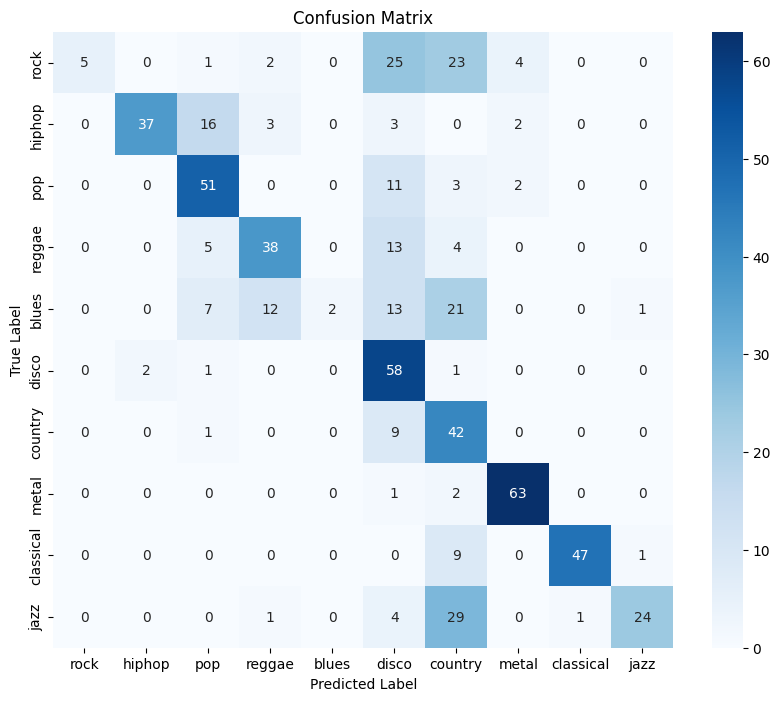

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(unnorm_data_test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,  # Label columns with true labels
            yticklabels=class_labels)  # Label rows with true labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

This cell trains the same model, but this time using the *normalized* data.  It's identical to the previous training cell, except it uses `norm_train_dataset` and `norm_test_dataset`.  The same callbacks (`early_stopping` and `reduce_lr`) are used to manage the training process.  This allows for a direct comparison of model performance between using normalized and unnormalized input data.

In [40]:
normalized_data_train_history = norm_dataset_model.fit(
    norm_train_dataset,
    epochs=50,
    validation_data=norm_test_dataset,
    callbacks=[early_stopping, reduce_lr]  # Add the callback here
    )  # Adjust epochs and batch size as needed

Epoch 1/50
     75/Unknown 40s 484ms/step - accuracy: 0.3041 - loss: 2.4393

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 536ms/step - accuracy: 0.3054 - loss: 2.4355 - val_accuracy: 0.1100 - val_loss: 2.5828 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.5424 - loss: 1.7017 - val_accuracy: 0.1100 - val_loss: 2.7232 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.6243 - loss: 1.4308 - val_accuracy: 0.1233 - val_loss: 2.6762 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.6616 - loss: 1.2586 - val_accuracy: 0.2050 - val_loss: 2.4791 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.6930 - loss: 1.1477 - val_accuracy: 0.2317 - val_loss: 2.2815 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.7077 - loss: 1.0676 - val_accuracy: 0.2817 - val_loss: 2.0767 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.7277 - loss: 1.0055 - val_

This cell calls the `calculate_measures` function with `norm=1` (indicating normalized data) to evaluate the model's performance on the *normalized* test dataset. The returned evaluation metrics are stored in corresponding variables, allowing for comparison with the results obtained using unnormalized data.

In [41]:
norm_data_test_y_pred, norm_data_test_y_true, norm_data_test_accuracy, norm_data_test_loss, norm_data_test_f1, norm_data_test_precision, norm_data_test_recall, norm_data_test_cm = caluclate_measures(1)
class_labels = np.unique(unnorm_data_test_y_pred)
class_labels = [list_of_musics[i] for i in np.unique(norm_data_test_y_pred)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


In [42]:
print(f"Test Loss: {norm_data_test_loss}")
print(f"Test Accuracy: {norm_data_test_accuracy}")
print(f"F1-score: {norm_data_test_f1}")
print(f"Precision: {norm_data_test_precision}")
print(f"Recall: {norm_data_test_recall}")
print("Confusion Matrix:")
print(norm_data_test_cm)

Test Loss: 0.6748074293136597
Test Accuracy: 0.8016666769981384
F1-score: 0.7978004549606774
Precision: 0.8270679704570814
Recall: 0.7965534573333357
Confusion Matrix:
[[30  0  4  2  1  0 17  2  0  4]
 [ 2 45  9  1  0  0  0  3  0  1]
 [ 0  0 64  2  0  0  0  0  0  1]
 [ 0  0  4 46  0  2  0  0  0  8]
 [ 1  0  0  3 40  2  0  2  0  8]
 [ 3  3  2  0  0 49  0  0  1  4]
 [ 0  0  1  0  1  0 34  0  2 14]
 [ 2  0  0  0  0  0  0 64  0  0]
 [ 0  0  0  0  0  0  0  0 51  6]
 [ 0  0  0  0  0  0  0  0  1 58]]


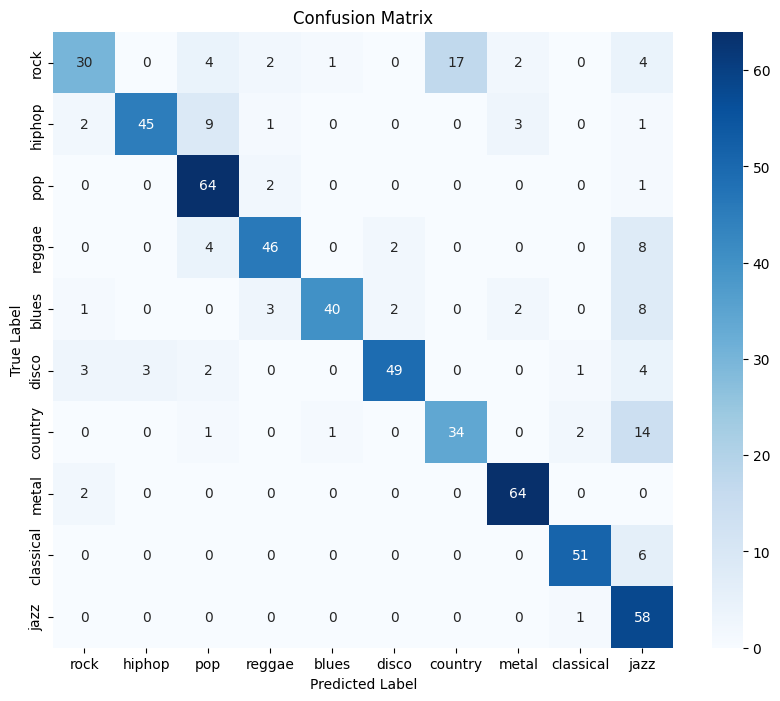

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(norm_data_test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,  # Label columns with true labels
            yticklabels=class_labels)  # Label rows with true labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()